[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IshmaGurca/AtomicNite/blob/main/notebooks/VoG_MetaLearning.ipynb)

# ACTIVE BATCH SAMPLE SEARCH

This notebook contains some ideas to mitigate the problem when facing new data sample which had not enough training data to
have a consistent model. The outline of the idea is as following:

- Identify prediction with new example has highly uncertain (e.g. via VOG)
- Initialize new training batch to re-train model based on new example (e.g. high cosine-similarity in latent space)
- Train model with extra batch for some EPOCH
- Calculate uncertainty measure of new example on re-trained model
- Calculate gradient of uncertainty measure in respect to initial latent space embeding of new batch to determin how to adjust the batch in order to redcue uncertainty after another re-training.
- Apply gradient descent step to latent space of new batch and determin change of next batch (e.g. via cosine-similarity to existing training data)

In [1]:
!pip install torch torchvision higher

In [2]:
### Import
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy, copy

import torch
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
import torchvision
import torch.nn.functional as F

import higher

In [3]:
### Set random set for pytorch model
seed = 0
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
### Load MNIST dataset

DATA_FOLDER = '../data'

mnist_train = torchvision.datasets.MNIST(DATA_FOLDER, download=True,train=True,
    transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
mnist_test = torchvision.datasets.MNIST(DATA_FOLDER, download=True,train=False,
    transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [5]:
### Skew the MNIST dataset
TRAIN_SIZE = 10000
TEST_SIZE = 1
BATCH_SIZE = 100

mnist_train_subset= Subset(mnist_train,list(WeightedRandomSampler((mnist_train.targets != 5) *0.9 + (mnist_train.targets == 5) *0.1, TRAIN_SIZE, replacement=False)))
mnist_test_subset = Subset(mnist_test,list(WeightedRandomSampler((mnist_test.targets == 5) *0.99 + (mnist_test.targets != 5) *0.01, TEST_SIZE, replacement=False)))

In [6]:
dataloader_train = DataLoader(mnist_train_subset, shuffle=True, batch_size=BATCH_SIZE)
dataloader_pool = DataLoader(mnist_train_subset, shuffle=False, batch_size=TRAIN_SIZE)
dataloader_test = DataLoader(mnist_test_subset, shuffle=True, batch_size=TEST_SIZE)

In [7]:
### Network Definition

class EmbNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = 20
        self.lin = torch.nn.Linear(28*28,self.hidden)
        self.bn = torch.nn.BatchNorm1d(self.hidden)

    def forward(self,x):
        x = x.reshape(x.shape[0],28*28)
        x = self.lin(x)
        #x = torch.sigmoid(x)
        x = self.bn(x)
        return x

class Classification_Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.emb_hidden = 20
        self.hidden = 20
        self.lin1 = torch.nn.Linear(self.emb_hidden,self.hidden)
        self.lin2a = torch.nn.Linear(self.hidden,self.hidden)
        self.lin2b = torch.nn.Linear(self.hidden,10)
         
    def  forward(self,x):
        x = self.lin1(x)
        x = torch.relu(x)
        x = self.lin2a(x)
        x = torch.relu(x)
        x = self.lin2b(x)
        return x

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.emb_net = EmbNet()
        self.net = Classification_Net()

    def forward(self,x):
        x_emb = self.emb_net(x)
        x = self.net(x_emb)
        return x, x_emb


network = Net()

In [8]:
#### PRE-TRAIN NETWORK #####
saved_models = []
EPOCHS_PRETRAIN = 10

para =   list(network.parameters())
optimizer = torch.optim.Adam(para,lr = 0.1)

for _ in range(EPOCHS_PRETRAIN):
    for x,y in dataloader_train:
        y_hat,_ = network(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    #### SAVE CHECKPOINTS OF MODEL
    saved_models.append(deepcopy(network.state_dict()))

In [9]:
#### TEST ON EXAMPLE

X_test, y_test = next(iter(dataloader_test))
X_pool, y_pool = next(iter(dataloader_pool))

In [10]:
### Define Variance of Gradient
def VoG(x,network, saved_models):
    x = torch.Tensor(x)
    x.requires_grad = True
    x = x.detach().requires_grad_()
    grads = []
    for net_dict in saved_models:
        network.load_state_dict(net_dict)
        y_test_hat, _ =  network(x)
        m,_ = torch.max(y_test_hat,axis=-1)
        grad = torch.autograd.grad(m, x, create_graph=True)
        grads.append(grad[0])

    grad_stack = torch.stack(grads)
    grad_stack = grad_stack.reshape(grad_stack.shape[0],grad_stack.shape[1],28*28).transpose(1,0)
    mean = torch.mean(grad_stack,axis=1, keepdim=False)
    var = torch.mean((grad_stack- torch.mean(grad_stack,axis=1, keepdim=True))**2,axis=1)
    return torch.mean(torch.mean((grad_stack- torch.mean(grad_stack,axis=1, keepdim=True))**2,axis=1),axis=-1), mean, var

### Function to Update VoG after starting re-training
def updatedVoG(VoG_mean_prior,VoG_var_prior,VoG_n_prior, VoG_mean_new, VoG_var_new, VoG_n_new):
    mean = (VoG_n_prior * VoG_mean_prior  + VoG_n_new * VoG_mean_new)/(VoG_n_prior + VoG_n_new )
    d_prior = (VoG_mean_prior - mean)**2
    d_new = (VoG_mean_new - mean)**2
    var = (VoG_n_prior * (VoG_var_prior + d_prior)  + VoG_n_new * (VoG_var_new + d_new))/(VoG_n_prior + VoG_n_new )
    return torch.mean(var), mean, var, VoG_n_prior +VoG_n_new

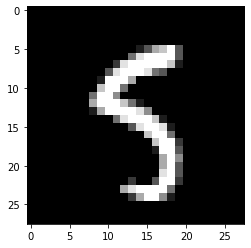

True Label: 5 Predicted Label: 8


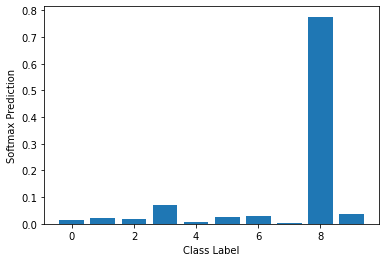

VoG of example: 0.0015204031951725483


In [11]:
#### TEST PRE-TRAINED
network.eval()
network.load_state_dict(saved_models[-1])

y_test_hat_pretrained, _ = network(X_test)
plt.imshow(X_test[0].reshape(28,28), cmap="gray")
plt.show()
print('True Label: {} Predicted Label: {}'.format(y_test.numpy()[0], torch.argmax(torch.nn.functional.softmax(y_test_hat_pretrained,dim=-1)).numpy()))

plt.bar(x = [i for i in range(10)], height= torch.nn.functional.softmax(y_test_hat_pretrained,dim=-1).detach().numpy()[0])
plt.ylabel('Softmax Prediction')
plt.xlabel('Class Label')
plt.show()

VOG_test_pretrain, VOG_test_pretrain_mean, VOG_test_pretrain_var = VoG(X_test,network,saved_models)

print('VoG of example: {}'.format(float(VOG_test_pretrain.detach().numpy())))

VoG Update: 0.0002533252991270274, VoG Total: 0.0009099752642214298
Labels of used examples


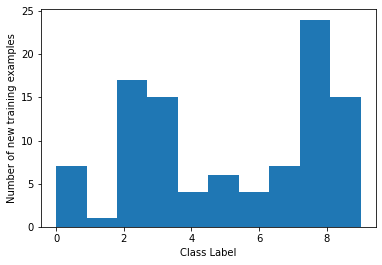

True Label: 5 Predicted Label: 5


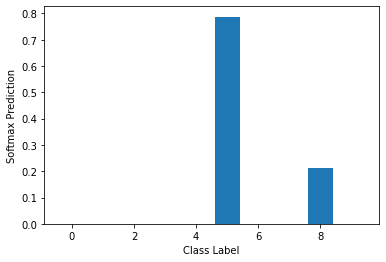

In [12]:
##### META TRAINING #### 
EPOCHS = 10
OUTER_LAMBDA = 1
OUTER_LOOPS = 100
RANDOM_FAKTOR = 0
RANDOM_FAKTOR_START = 0

sub_data = None

_,xx_emb =  network(X_test)
_,x_pool_emb =  network(X_pool)

sim = torch.stack([torch.nn.functional.cosine_similarity(xx_emb[0],x_pool_emb, dim = -1) for i in range(BATCH_SIZE)])

sim_idx = torch.argmax(sim,dim=-1)

_,sim_idx  = torch.topk(torch.nn.functional.cosine_similarity(xx_emb[0],x_pool_emb, dim = -1),BATCH_SIZE)
rnd_idx = torch.randint_like(sim_idx,len(mnist_train_subset))
rnd = torch.rand(rnd_idx.shape)
idx = rnd_idx * (rnd <= RANDOM_FAKTOR_START)  + sim_idx * (rnd > RANDOM_FAKTOR_START)
sub_data = torch.utils.data.Subset(mnist_train_subset,idx)

outer_losses = []
inner_losses = []
y_history = []

meta_loss_prior = VOG_test_pretrain.detach().numpy()[0]
meta_loss_mean_prior = VOG_test_pretrain_mean
meta_loss_var_prior = VOG_test_pretrain_var
meta_loss_n_prior = EPOCHS_PRETRAIN

meta_loss_fn_p = 100

for _ in range(OUTER_LOOPS):

    para =  list(network.parameters()) #list(network.net.parameters())
    optimizer = torch.optim.Adam(para,lr = 0.1)
    if sub_data is None:
        dataloader_train = DataLoader(mnist_train_subset, shuffle=True, batch_size=BATCH_SIZE)
        print('HELLO')
    else:
        dataloader_train = DataLoader(sub_data, shuffle=False, batch_size=BATCH_SIZE)
    x, y = next(iter(dataloader_train))

    grads= []

    X_test_w_grad = deepcopy(X_test)
    X_test_w_grad =  X_test_w_grad.detach().requires_grad_()
    _, x_pool_emb = network(X_pool)
    with higher.innerloop_ctx(network, optimizer,copy_initial_weights=False) as (fmodel,diffopt):
        for ii in range(EPOCHS):
            fmodel.train()
            if ii == 0:
                y_hat,x_emb =  fmodel(x)
            else:
                y_hat,_ =  fmodel(x)
            loss = torch.nn.functional.cross_entropy(y_hat, y)
            diffopt.step(loss)

            fmodel.eval()
            y_test_hat, _ =  fmodel(X_test_w_grad)
            m,_ = torch.max(y_test_hat,axis=-1)
            grad = torch.autograd.grad(m, X_test_w_grad, create_graph=True)
            grads.append(grad[0])



        grad_stack = torch.stack(grads)
        grad_stack = grad_stack.reshape(grad_stack.shape[0],grad_stack.shape[1],28*28).transpose(1,0)
        meta_loss_fn_mean = torch.mean(grad_stack,axis=1, keepdim=False)
        meta_loss_fn_var = torch.mean((grad_stack- torch.mean(grad_stack,axis=1, keepdim=True))**2,axis=1)

        meta_loss_fn,  mean, var, n = updatedVoG(meta_loss_mean_prior ,meta_loss_var_prior , meta_loss_n_prior, meta_loss_fn_mean ,meta_loss_fn_var , EPOCHS)
        y_hat_test, x_test_emb = fmodel(X_test)
    

        meta_loss  = float(meta_loss_fn.detach().numpy())
        meta_loss_var = float(torch.mean(meta_loss_fn_var).detach().numpy())

        outer_losses.append(meta_loss)

        grad_of_grads = torch.autograd.grad(meta_loss_fn, x_emb) 
        xx_emb =  x_emb -  OUTER_LAMBDA * torch.nn.functional.normalize(grad_of_grads[0])
     
   
    if meta_loss < meta_loss_prior and meta_loss_var != 0:
        print('VoG Update: {}, VoG Total: {}'.format(meta_loss_var, meta_loss))
        meta_loss_prior = meta_loss 
        best_statedict = deepcopy(fmodel.state_dict())
        y_history.append(y.numpy())

        ##### UN-COMMENT TO SEE USE BATCH LABELS
        #plt.hist(y.numpy())
        #plt.show()
            
        meta_loss_prior = meta_loss
        meta_loss_mean_prior = mean
        meta_loss_var_prior = var
        meta_loss_n_prior = n
        network = Net()
        network.load_state_dict(deepcopy(fmodel.state_dict()))
        network.eval()
    
    sim = torch.stack([torch.nn.functional.cosine_similarity(xx_emb[i],x_pool_emb, dim = -1) for i in range(BATCH_SIZE)])
    
    sim_idx = torch.argmax(sim,dim=-1)
    rnd_idx = torch.randint_like(sim_idx,len(mnist_train_subset))
    rnd = torch.rand(rnd_idx.shape)
    idx = rnd_idx * (rnd <= RANDOM_FAKTOR)  + sim_idx * (rnd > RANDOM_FAKTOR)
    sub_data = torch.utils.data.Subset(mnist_train_subset,idx)
    dataloader_train = DataLoader(sub_data, shuffle=False, batch_size=BATCH_SIZE)

network.load_state_dict(best_statedict)

print('Labels of used examples')
plt.hist(np.concatenate(y_history))
plt.ylabel('Number of new training examples')
plt.xlabel('Class Label')
plt.show()

y_test_hat_pretrained, _ = network(X_test)
print('True Label: {} Predicted Label: {}'.format(y_test.numpy()[0], torch.argmax(torch.nn.functional.softmax(y_test_hat_pretrained,dim=-1)).numpy()))

plt.bar(x = [i for i in range(10)], height= torch.nn.functional.softmax(y_test_hat_pretrained,dim=-1).detach().numpy()[0])
plt.ylabel('Softmax Prediction')
plt.xlabel('Class Label')
plt.show()